### Pivot Point

<font color='orange'>
    Pivot points are used to identify market movements, based on the high, low and closing price of the previous day. If the market in the next session trades above the pivot point this is seen to be bullish, whereas if the market trades below the pivot point it is seen to be bearish.
</font>

<font color='orange'>
    The usual system used is the five-point system. This uses the previous high, low and close, and then also employs two extra support levels and two additional resistance levels to provide five pivot points. This is calculated in the following way:
    \begin{aligned}
    & \text{Pivot point} = (\operatorname{previous high + previous low + previous close} ) / 3 \\
    & \text{Support 1 = (pivot point $\times$2) - previous high} \\
    & \text{Support 2 = pivot point - (previous high - previous low)} \\
    & \text{Resistance 1 = (pivot point $\times$ 2) - previous low} \\
    & \text{Resistance 2 = pivot point + (previous high - previous low)} \\
    \end{aligned}
</font>

<font color='orange'>
    Like all other indicators, there are other ways of calculating pivot points, and also many ways of interpreting these 5 points. The consensus is that:
    <ul>
        <li> Price above PP signals bullish sentiment -> go long </li> 
        <li>Price below PP signals bearish sentiment -> go short</li>
    </ul>
</font>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")

In [2]:
data = pd.read_csv('./data/EURUSD_pivot.csv', index_col = 'time', parse_dates = ['time'])
data.head()

,Open,High,Low,Close
time,,,,
2019-01-01 22:00:00,1.14649,1.14658,1.14630,1.14648
2019-01-01 22:30:00,1.14653,1.14653,1.14616,1.14641
2019-01-01 23:00:00,1.14640,1.14678,1.14579,1.14665
2019-01-01 23:30:00,1.14669,1.14672,1.14614,1.14614
2019-01-02 00:00:00,1.14614,1.14628,1.14575,1.14582


#### Data preparation

* Timezone conversion 

In [3]:
# Localize to UTC time
data = data.tz_localize("UTC")
data.index.tz

datetime.timezone.utc

In [4]:
# Convert to US/Eastern (NY) time
data = data.tz_convert("US/Eastern")
data.index.tz

<DstTzInfo 'US/Eastern' LMT-1 day, 19:04:00 STD>

* Daily price resampling

In [5]:
# Perform different aggregation on OHLC
agg_dict = {'Open': 'first',
            'High': 'max',
            'Low': 'min',
            'Close': 'last'}
data_daily = data.resample('D', offset='17H').agg(agg_dict).dropna()

In [6]:
# Rename resampled dataframe
data_daily.columns = ['Open_d', 'High_d', 'Low_d', 'Close_d']

In [7]:
data = data.join(data_daily.shift().dropna()).ffill().dropna()

#### Add Pivot Point and Support and Resistance Lines

* __Pivot Point Line__: The average of the previous day‘s High, Low and Close price

In [8]:
data['PP'] = (data.High_d + data.Low_d + data.Close_d) / 3

* __S1 and S2 Support Lines__

In [9]:
data['S1'] = data.PP * 2 - data.High_d

In [10]:
data['S2'] = data.PP - (data.High_d - data.Low_d )

* __R1 and R2 Resistance Lines__

In [11]:
data['R1'] = data.PP * 2 - data.Low_d

In [12]:
data['R2'] = data.PP + (data.High_d - data.Low_d )

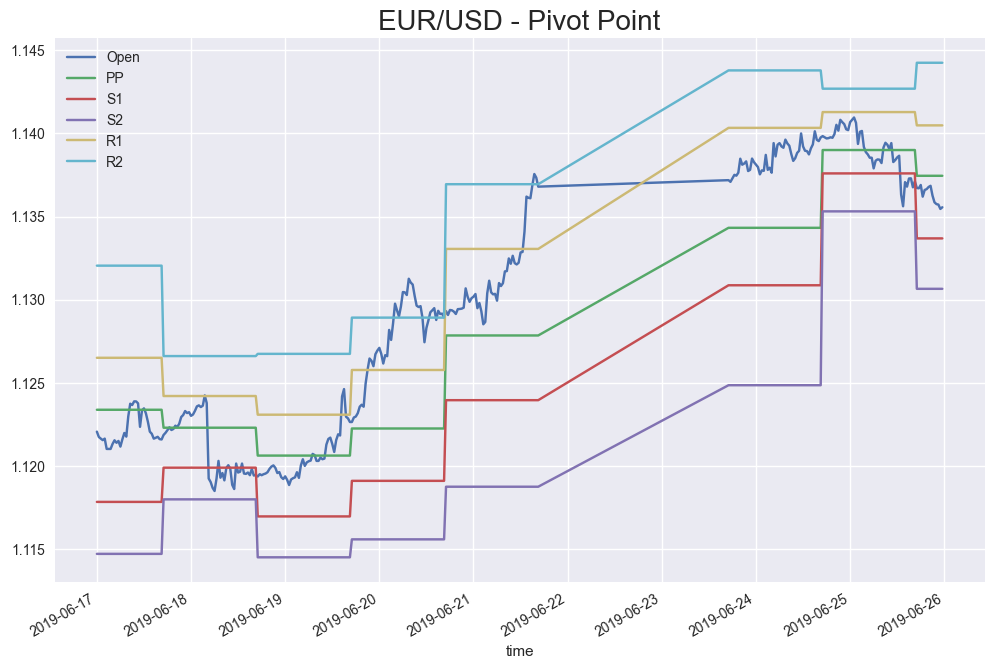

In [13]:
data.loc['2019-06-17':'2019-06-25', 
['Open', 'PP', 'S1', 'S2', 'R1', 'R2']].plot(figsize = (12, 8))
plt.title('EUR/USD - Pivot Point', fontsize = 20)
plt.show()

#### Simple Pivot Point Strategy

__S1/R1 signal end of trend as probability of reversal increases (exit points)__:

* If the price reaches S1 -> go neutral
* If the price reaches R1 -> go neutral

In [14]:
data['position'] = np.where(data.Open > data.PP, 1, -1)

In [15]:
data['position'] = np.where(data.Open >= data.R1, 0, data.position)

In [16]:
data['position'] = np.where(data.Open <= data.S1, 0, data.position)

In [17]:
data.position = data.position.fillna(0)

In [18]:
# Obtain log return of buy-and-hold
data['return'] = np.log(data.Open.shift(-1).div(data.Open))

In [19]:
# Obtain log return of pivot point strategy
data['strategy'] = data.position * data['return']
data.dropna(inplace = True)

In [20]:
TRADING_COST = 0.00007

In [21]:
# Make a trade once position changes
data['trades'] = data.position.diff().fillna(0).abs()

In [22]:
# Obtain log return of pivot point strategy excluding trading cost
data['strategy_net'] = data.strategy - data.trades * TRADING_COST

In [23]:
data['return(cum)'] = data['return'].cumsum().apply(np.exp)
data['strategy(cum)'] = data['strategy'].cumsum().apply(np.exp)
data['strategy_net(cum)'] = data['strategy_net'].cumsum().apply(np.exp)

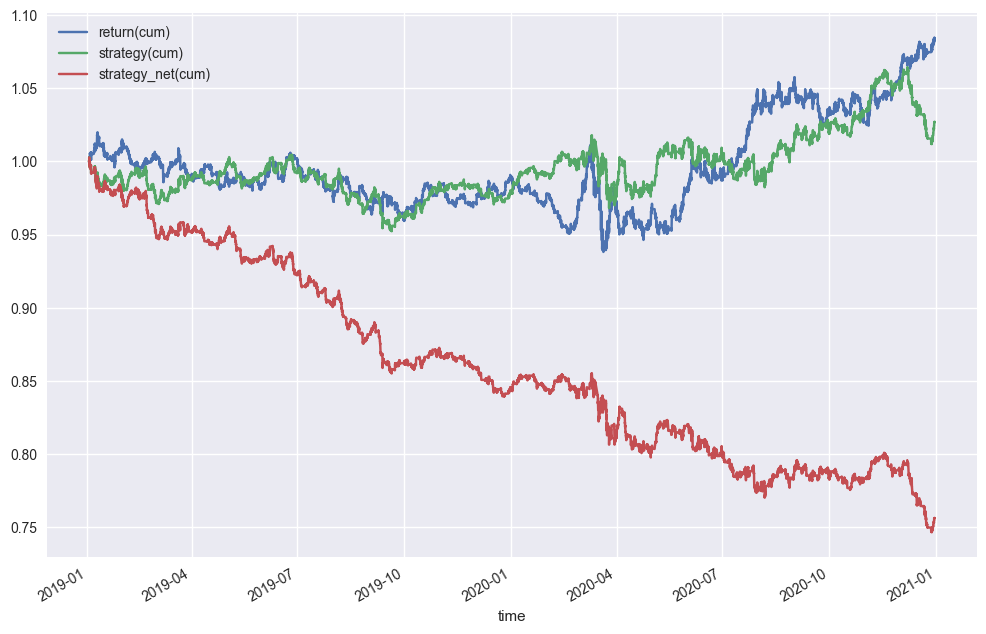

In [24]:
data[['return(cum)', 'strategy(cum)', 'strategy_net(cum)']].plot(figsize = (12 , 8))
plt.show()